In [10]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm
from shapely.geometry import LineString, MultiLineString, box

In [3]:
transmission_lines_path = Path.cwd().parent.parent / 'data' / 'raw' / 'brasil' / 'infraestrutura_eletrica' / 'linha_transmissao.geojson'
transmission_lines = gpd.read_file(transmission_lines_path)
transmission_lines.columns = transmission_lines.columns.str.lower()

datacenters_path = Path.cwd().parent.parent / 'data' / 'processed' / 'brasil' / 'processed_datacentermap.csv'
datacenters = pd.read_csv(datacenters_path)
datacenters.replace("", np.nan, inplace=True)

# Convert datacenters to GeoDataFrame
gdf_datacenters = gpd.GeoDataFrame(
    datacenters, 
    geometry=gpd.points_from_xy(datacenters["longitude"], datacenters["latitude"]),
    crs="EPSG:4326"
)

In [4]:
substations_path = Path.cwd().parent.parent / 'data' / 'raw' / 'brasil' / 'infraestrutura_eletrica' / 'subestacao.geojson'
substations = gpd.read_file(substations_path)
substations.dropna(subset=['INS_ID'], inplace=True)

/var/folders/wy/sh80l6n90g521zb1r40wbjs00000gn/T/ipykernel_25107/691415480.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_voltages))


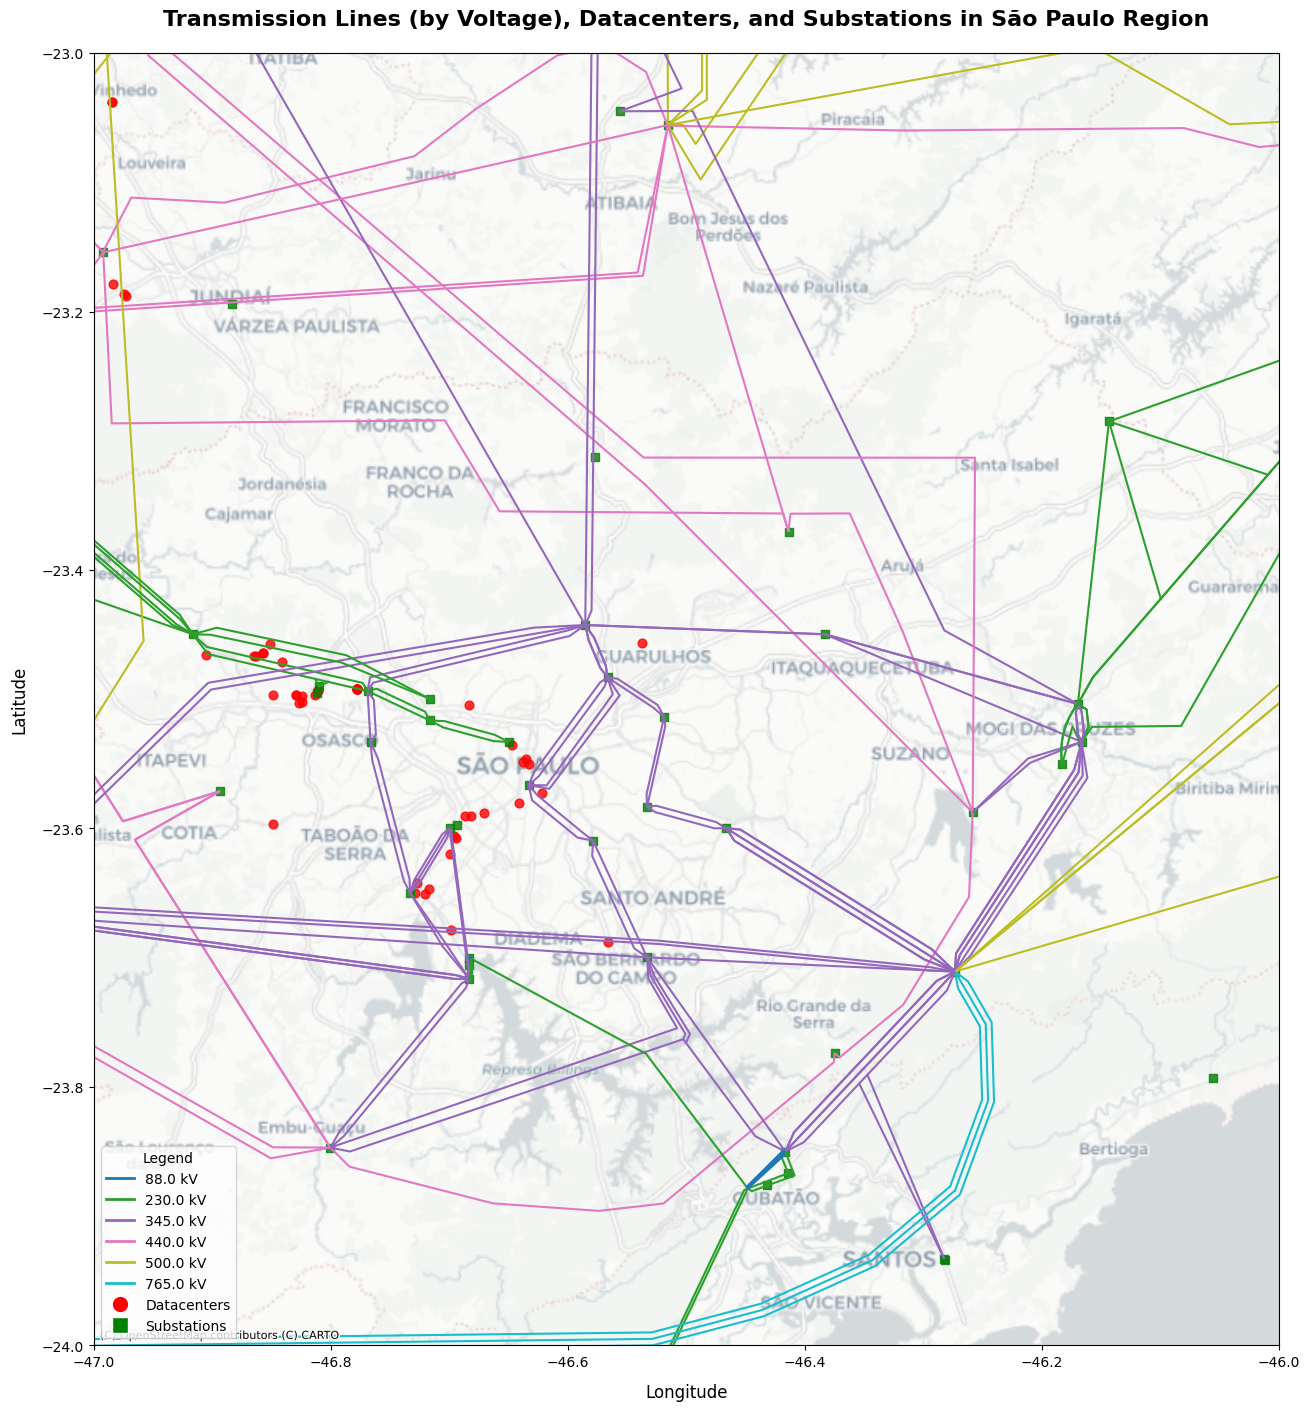

In [11]:
# Define a bounding box for a region in São Paulo (example values)
sao_paulo_bbox = {
    "minx": -47.0,
    "maxx": -46.0,
    "miny": -24.0,
    "maxy": -23.0
}

# Create a bounding box polygon from the dictionary
bbox_poly = box(sao_paulo_bbox["minx"], sao_paulo_bbox["miny"],
                sao_paulo_bbox["maxx"], sao_paulo_bbox["maxy"])

# Filter transmission lines using spatial intersection with the bbox polygon
transmission_lines_filtered = transmission_lines[transmission_lines.geometry.intersects(bbox_poly)]

# Filter datacenters based on whether their point geometry lies within the bbox polygon
gdf_datacenters_filtered = gdf_datacenters[gdf_datacenters.geometry.intersects(bbox_poly)]

# Filter substations similarly
gdf_substations_filtered = substations[substations.geometry.intersects(bbox_poly)]

# Create a mapping from voltage to a unique color
unique_voltages = sorted(transmission_lines_filtered['voltage'].dropna().unique())
cmap = cm.get_cmap('tab10', len(unique_voltages))
voltage_colors = {voltage: cmap(i) for i, voltage in enumerate(unique_voltages)}

# Create the plot
fig, ax = plt.subplots(figsize=(14, 14), constrained_layout=True)

# Plot Transmission Lines with colors by voltage
for idx, row in transmission_lines_filtered.iterrows():
    geom = row.geometry
    voltage = row['voltage']
    # If voltage is missing, default to gray
    color = voltage_colors.get(voltage, "#808080")
    if isinstance(geom, LineString):
        x, y = geom.xy
        ax.plot(x, y, color=color, linewidth=1.5)
    elif isinstance(geom, MultiLineString):
        for segment in geom.geoms:
            x, y = segment.xy
            ax.plot(x, y, color=color, linewidth=1.5)

# Plot Datacenters as red circles
gdf_datacenters_filtered.plot(ax=ax, color="red", markersize=40, label="Datacenters", alpha=0.8)

# Plot Substations as green squares
gdf_substations_filtered.plot(ax=ax, color="green", markersize=30, marker="s", label="Substations", alpha=0.8)

# Set the plot extent to the bounding box
ax.set_xlim(sao_paulo_bbox["minx"], sao_paulo_bbox["maxx"])
ax.set_ylim(sao_paulo_bbox["miny"], sao_paulo_bbox["maxy"])

# Add a basemap (using CartoDB Positron style)
ctx.add_basemap(ax, crs=gdf_datacenters_filtered.crs, source=ctx.providers.CartoDB.Positron)

# Format the plot
ax.set_title("Transmission Lines (by Voltage), Datacenters, and Substations in São Paulo Region", 
             fontsize=16, pad=20, weight="bold")
ax.set_xlabel("Longitude", fontsize=12, labelpad=10)
ax.set_ylabel("Latitude", fontsize=12, labelpad=10)

# Create a legend entry for each voltage level
voltage_legend_elements = [mlines.Line2D([], [], color=color, linewidth=2, label=f"{voltage} kV")
                           for voltage, color in voltage_colors.items()]

# Add legend entries for Datacenters and Substations
other_legend_elements = [
    mlines.Line2D([], [], marker='o', color='red', markeredgecolor='white',
                  markersize=12, linestyle='None', label="Datacenters"),
    mlines.Line2D([], [], marker='s', color='green', markeredgecolor='white',
                  markersize=12, linestyle='None', label="Substations")
]

# Combine all legend elements and add to the plot
legend_elements = voltage_legend_elements + other_legend_elements
ax.legend(handles=legend_elements, loc="lower left", fontsize=10, title="Legend", frameon=True)

# Show the map
plt.show()


In [6]:
transmission_lines['voltage'] = transmission_lines.nomelongo.str.extract(r'(\d+)').astype(float)

In [35]:
gdf_datacenters.sort_values('MW').dropna(subset=['MW'])

,Unnamed: 0,url,address,cep,MW,sq.m,Est,sq.f,latitude,longitude,geometry
59,59,https://www.datacentermap.com/brazil/curitiba/...,"Next Stream Rua Senador Accioly Filho, 2200 81...",81350-200,0.7,582,NaN,NaN,-25.495343,-49.328516,POINT (-49.32852 -25.49534)
21,21,https://www.datacentermap.com/brazil/sao-paulo...,"Latitude.sh Rua Dr. Eduardo Martinelli, 100 04...",04013050,1.0,400,2016.0,NaN,-23.580060,-46.641200,POINT (-46.6412 -23.58006)
40,40,https://www.datacentermap.com/brazil/sao-paulo...,"TAKODAAv. Maria Coelho Aguiar, 215 - Jardim Sa...",05805-000,1.0,NaN,NaN,NaN,-23.650152,-46.729392,POINT (-46.72939 -23.65015)
133,133,https://www.datacentermap.com/brazil/palmas/id...,IDX Data Centers & IT Services Q. 103 Sul Rua ...,NaN,1.2,250,2022.0,NaN,-10.187526,-48.340776,POINT (-48.34078 -10.18753)
143,143,https://www.datacentermap.com/brazil/blumenau/...,"Unifique R. Duque de Caxias, 831 - Centro89120...",89120-000,1.5,685,NaN,NaN,-26.823280,-49.280098,POINT (-49.2801 -26.82328)
...,...,...,...,...,...,...,...,...,...,...,...
122,122,https://www.datacentermap.com/brazil/campinas/...,Cloud HQParque das Indústrias13140-0000 Paulín...,13140-000,48.0,"18,055",NaN,NaN,-22.769619,-47.151153,POINT (-47.15115 -22.76962)
52,52,https://www.datacentermap.com/brazil/porto-ale...,Quântico Data Center R. Eng. Homero Carlos Sim...,92442000,50.0,NaN,2021.0,"73,000",-32.035000,-52.098610,POINT (-52.09861 -32.035)
81,81,https://www.datacentermap.com/brazil/rio-de-ja...,Ada Infrastructure Rua Oliveira Roxo25240-080 ...,25240-080,60.0,NaN,NaN,NaN,-22.705812,-43.232343,POINT (-43.23234 -22.70581)
80,80,https://www.datacentermap.com/brazil/rio-de-ja...,"Cirion Av. Pedro II, 23520941 Rio de Janeiro B...",23520941,60.0,NaN,2026.0,NaN,-22.935707,-43.673350,POINT (-43.67335 -22.93571)
